In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [20]:
!unzip "/content/drive/My Drive/Final_Bachelor_Project/NewVersion/dataset/5k_2points_ds.zip" -d "/content/dataset"

In [4]:
labels_path = '/content/dataset/5k_2points_ds/labels'
images_path = '/content/dataset/5k_2points_ds/images'

In [5]:
def get_coordinates(base_dir):
    coordinates = list()
    for root, _, files in os.walk(base_dir):
      for name in sorted(files):
        if 'txt' in name:
          file_path = os.path.join(root, name)
          current_file_coords = list()
          with open(file_path, 'r') as f:
            lines = f.read().splitlines()
            
          for coord in lines[:-1]:
            arr = coord.split(',')
            arr = list(map(int, arr))
            for item in arr:
              current_file_coords.append(item)

            
          coordinates.append(current_file_coords)
    return coordinates

In [6]:
#this function is for getting images and processing them and put them into an array
def get_X(base_dir, img_size = [224, 64]):
  list_of_images = list()
  for root, _, files in os.walk(base_dir):
    for name in sorted(files):
      if 'jpeg' in name:
        file_path = os.path.join(base_dir, name)

        image = tf.keras.preprocessing.image.load_img(file_path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = image_arr / 255
        image_arr = tf.constant(image_arr)
        image = tf.image.resize(image_arr, img_size)
        list_of_images.append(image)

  
  return list_of_images

In [7]:
images = get_X(images_path)
coordinates = get_coordinates(labels_path)

In [8]:
def shuffle_data(coordinates, images):
    concatenated_array = np.array(list(zip(coordinates, images)))
    np.random.shuffle(concatenated_array)
    shuffled_coordinates = list()
    shuffled_images = list()

    for i in concatenated_array:

      shuffled_coordinates.append(i[0])
      shuffled_images.append(i[1])

    return tf.constant(shuffled_coordinates), shuffled_images


In [9]:
coordinates, images = shuffle_data(coordinates, images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [10]:
coordinates.shape, np.array(images).shape

(TensorShape([4479, 4]), (4479, 224, 64, 3))

In [11]:
x_test = images[:250]
coords_test = coordinates[:250]

In [12]:
coordinates = coordinates[250:]
images = images[250:]

In [13]:
def Build_Inception_Block(inputs, filters, kernel_size1, kernel_size2, activation = 'relu', regulizer_lambda = 0.01):
  x = tf.keras.layers.Conv2D(filters, (1, 1), activation = activation)(inputs)
  
  conv1 = tf.keras.layers.Conv2D(filters  , kernel_size1, activation = activation, padding = 'same', kernel_regularizer=tf.keras.regularizers.L1(regulizer_lambda))(x)

  conv2 = tf.keras.layers.Conv2D(filters  , kernel_size2, activation = activation, padding = 'same' , kernel_regularizer=tf.keras.regularizers.L1(regulizer_lambda))(x)

  x = tf.keras.layers.Concatenate()([x, conv1, conv2])

  return x


In [15]:
def Build_complete_Block(inputs, filters, kernel_size1, kernel_size2, activation = 'relu', regulizer_lambda = 0.01):
  x = tf.keras.layers.Conv2D(filters, (1, 1), activation = activation)(inputs)
  
  conv1 = tf.keras.layers.Conv2D(filters  , kernel_size1, activation = activation, padding = 'same', kernel_regularizer=tf.keras.regularizers.L1(regulizer_lambda))(x)
  res_block1 = Build_ResNet_Block(conv1, filters, kernel_size1, 'relu')
  conv2 = tf.keras.layers.Conv2D(filters //2  , kernel_size1, activation = activation, padding = 'same', kernel_regularizer=tf.keras.regularizers.L1(regulizer_lambda))(res_block1)
  b1 = tf.keras.layers.BatchNormalization()(conv2)

  conv3 = tf.keras.layers.Conv2D(filters  , kernel_size2, activation = activation, padding = 'same' , kernel_regularizer=tf.keras.regularizers.L1(regulizer_lambda))(x)
  res_block2 = Build_ResNet_Block(conv3, filters, kernel_size2, 'relu')
  conv4 = tf.keras.layers.Conv2D(filters // 2  , kernel_size2, activation = activation, padding = 'same' , kernel_regularizer=tf.keras.regularizers.L1(regulizer_lambda))(res_block2)
  b2 = tf.keras.layers.BatchNormalization()(conv4)

  x = tf.keras.layers.Concatenate()([x, b1, b2])

  return x


In [14]:
def Build_ResNet_Block(x, filter, kernel_size, activation = 'relu', regulizer_lambda = 0.01):

    x_skip = x
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same', activation = activation,  kernel_regularizer=tf.keras.regularizers.L1(regulizer_lambda))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same', activation = activation,  kernel_regularizer=tf.keras.regularizers.L1(regulizer_lambda))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [16]:
inputs = tf.keras.layers.Input(shape = (224, 64, 3))


block1 = Build_Inception_Block(inputs, 8, (3,3), (5,5), 'relu', regulizer_lambda = 0.7)
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(block1)
block2 = Build_complete_Block(pool_1, 8, (3,3), (5,5), 'relu')
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(block2)
block3 = Build_complete_Block(pool_1, 8, (3,3), (5,5), 'relu', regulizer_lambda = 0.4)
pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(block3)
dp = tf.keras.layers.Dropout(0.5)(pool_3)
block4 = Build_complete_Block(dp, 8, (3,3), (5,5), 'relu', regulizer_lambda = 0.4)
block5 = Build_complete_Block(block4, 8, (3,3), (5,5), 'relu', regulizer_lambda = 0.4)
pool_4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(block5)
block6 = Build_Inception_Block(pool_4, 8, (3,3), (5,5), 'relu', regulizer_lambda = 0.4)
block7 = Build_Inception_Block(block6, 8, (3,3), (5,5), 'relu', regulizer_lambda = 0.4)



x = tf.keras.layers.Flatten()(block7)
y2_output = tf.keras.layers.Dense(4)(x)

model = tf.keras.Model(inputs = inputs, outputs = y2_output)


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 224, 64, 8)   32          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 64, 8)   584         ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 224, 64, 8)   1608        ['conv2d[0][0]']             

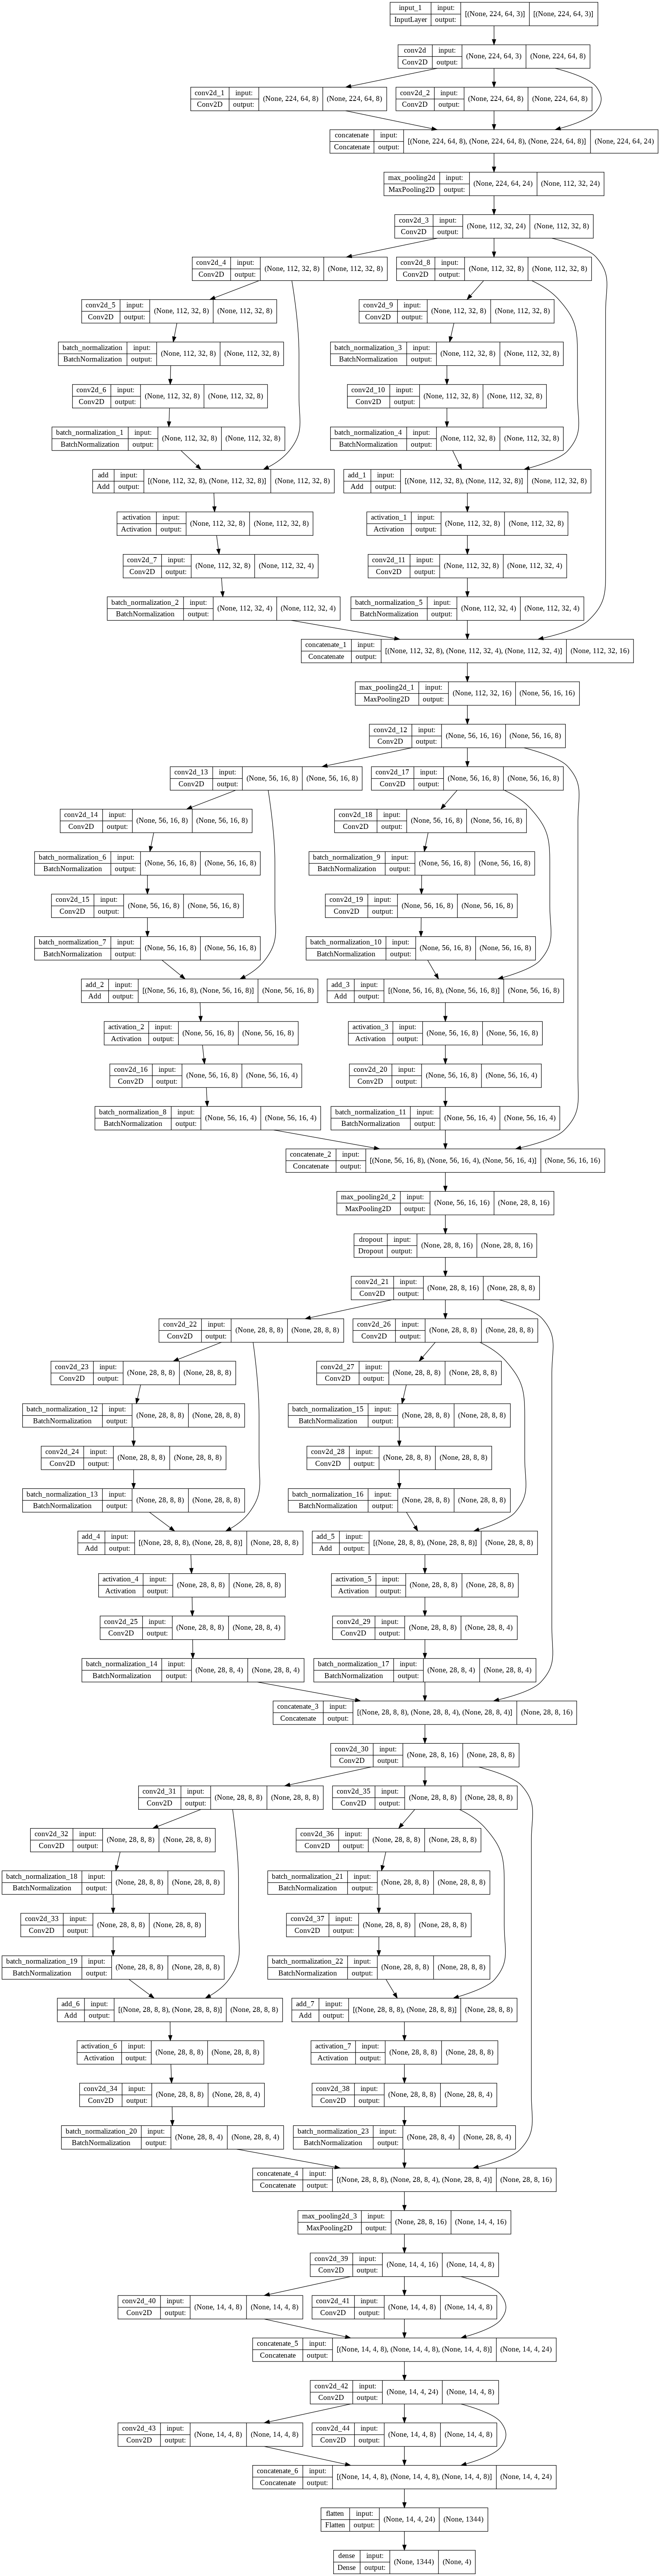

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer = Adam(learning_rate= 0.001),
              loss = 'mse',
              metrics = 'mse')

In [ ]:
history = model.fit(np.array(images), coordinates,
                    validation_split = 0.2,
                    batch_size = 32,
                    epochs = 50,
                    callbacks = [ModelCheckpoint('drive/MyDrive/two_points/5_shahrivar/regression_model_{epoch:03d}.h5',
                                                     verbose = 1)])

Epoch 1/50
106/106 [==============================] - ETA: 0s - loss: 59.4210 - mse: 29.0460
Epoch 1: saving model to drive/MyDrive/two_points/5_shahrivar/regression_model_001.h5
106/106 [==============================] - 7s 66ms/step - loss: 59.4210 - mse: 29.0460 - val_loss: 73.3865 - val_mse: 41.7018
Epoch 2/50
106/106 [==============================] - ETA: 0s - loss: 66.1230 - mse: 33.9107
Epoch 2: saving model to drive/MyDrive/two_points/5_shahrivar/regression_model_002.h5
106/106 [==============================] - 6s 54ms/step - loss: 66.1230 - mse: 33.9107 - val_loss: 81.4632 - val_mse: 49.0354
Epoch 3/50
106/106 [==============================] - ETA: 0s - loss: 56.5483 - mse: 25.3342
Epoch 3: saving model to drive/MyDrive/two_points/5_shahrivar/regression_model_003.h5
106/106 [==============================] - 6s 54ms/step - loss: 56.5483 - mse: 25.3342 - val_loss: 88.8390 - val_mse: 57.8329
Epoch 4/50
105/106 [============================>.] - ETA: 0s - loss: 54.4621 - mse: 

In [ ]:
data = history.history

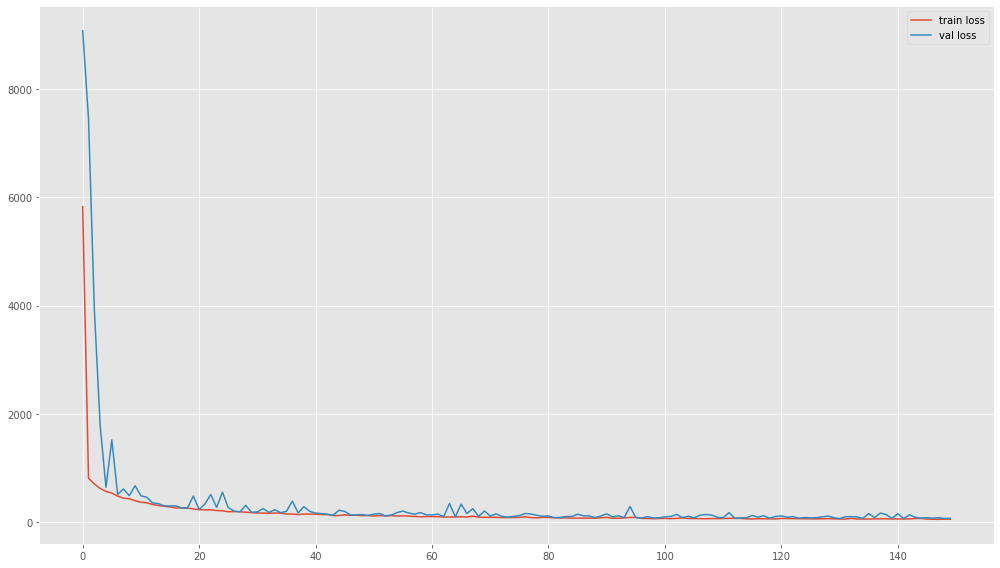

In [ ]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(14,8))
ax.plot(data['loss'], label = 'train loss')
ax.plot(data['val_loss'], label = 'val loss')
fig.tight_layout()
ax.legend()
plt.show()

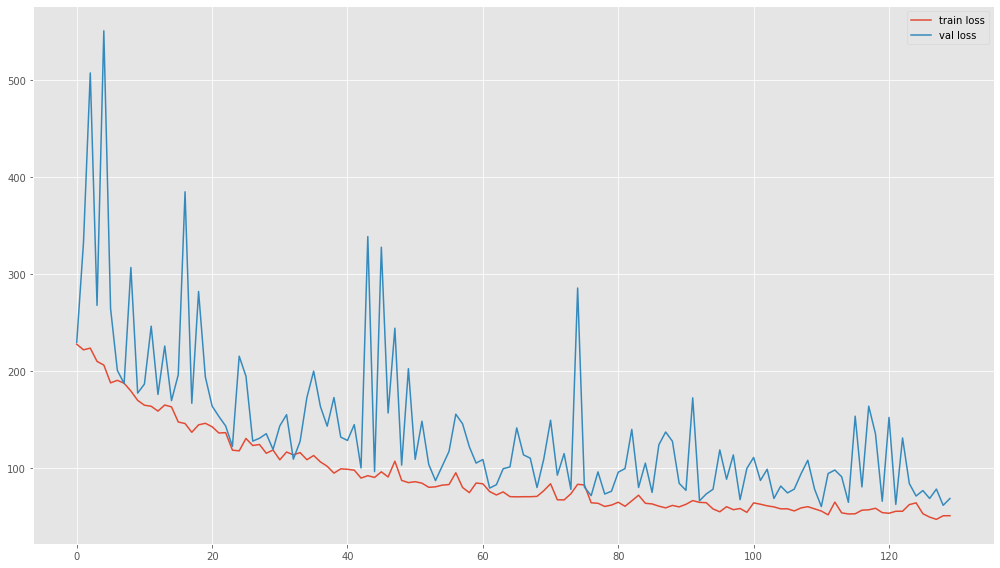

In [ ]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(14,8))
ax.plot(data['loss'][20:], label = 'train loss')
ax.plot(data['val_loss'][20:], label = 'val loss')
fig.tight_layout()
ax.legend()
plt.show()

In [18]:
model = tf.keras.models.load_model('phase2_model.h5')

In [19]:
model.evaluate(np.array(x_test), coords_test, batch_size = 32)

8/8 [==============================] - 11s 52ms/step - loss: 46.7837 - mse: 18.6223


[46.78373336791992, 18.6223201751709]